In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv(r'appian-x-iit-madras-hackathon-april-2025\train.csv')
test = pd.read_csv(r'appian-x-iit-madras-hackathon-april-2025\test.csv')

data.replace('Alone', 'Single', inplace=True)
test.replace('Absurd', 'Single', inplace=True)
data.replace('YOLO', 'Single', inplace=True)
test.replace('YOLO', 'Single', inplace=True)
# test.replace('Alone', 'Single', inplace=True)
# data.replace('Together', 'Married', inplace=True)
# test.replace('Together', 'Married', inplace=True)

# test.replace('Basic', '2n Cycle', inplace=True)
# data.replace('Basic', '2n Cycle', inplace=True)
# test.replace('Widow', 'Divorced', inplace=True)
# data.replace('Widow', 'Divorced', inplace=True)

data['Dt_Customer_1'] = pd.to_datetime(data['Dt_Customer'],format='mixed')
data['Dt_Customer_1'] = data['Dt_Customer_1']-min(data['Dt_Customer_1'])
data['Dates']=data['Dt_Customer_1'].dt.days

test['Dt_Customer_1'] = pd.to_datetime(test['Dt_Customer'],format='mixed')
test['Dt_Customer_1'] = test['Dt_Customer_1']-min(test['Dt_Customer_1'])
test['Dates']=test['Dt_Customer_1'].dt.days
Education = {}
Marital_status = {}
A = data['Education'].unique()
B = data['Marital_Status'].unique()
# A = test['Education'].unique()
# B = test['Marital_Status'].unique()
for i, category in enumerate(A):
    l = [0]*len(A)
    l[i] = 1
    print(f"{i}: {category}")
    Education[category] = i
for i, category in enumerate(B):
    l = [0]*len(B)
    l[i] = 1
    print(f"{i}: {category}")
    Marital_status[category] = i
data['Education'] = data['Education'].map(Education)
test['Education'] = test['Education'].map(Education)
data['Marital_Status'] = data['Marital_Status'].map(Marital_status)
test['Marital_Status'] = test['Marital_Status'].map(Marital_status)

# data = pd.get_dummies(data, columns=['Marital_Status', 'Education'], drop_first=True)
# test = pd.get_dummies(test, columns=['Marital_Status', 'Education'], drop_first=True)

0: Graduation
1: PhD
2: Master
3: Basic
4: 2n Cycle
0: Single
1: Together
2: Married
3: Divorced
4: Widow


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   ID                   1567 non-null   int64          
 1   Year_Birth           1567 non-null   int64          
 2   Education            1567 non-null   int64          
 3   Marital_Status       1567 non-null   int64          
 4   Income               1550 non-null   float64        
 5   Kidhome              1567 non-null   int64          
 6   Teenhome             1567 non-null   int64          
 7   Dt_Customer          1567 non-null   object         
 8   Recency              1567 non-null   int64          
 9   MntWines             1544 non-null   float64        
 10  MntFruits            1567 non-null   int64          
 11  MntMeatProducts      1561 non-null   float64        
 12  MntFishProducts      1567 non-null   int64          
 13  MntSweetProducts  

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np

categorical_cols = ['Education', 'Marital_Status']
numerical_cols = [
    'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
    'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
    'AcceptedCmp5', 'NumWebPurchases', 'NumCatalogPurchases',
    'NumStorePurchases', 'NumWebVisitsMonth', 'Dates'
]
lists = [
    'Year_Birth',
    'Income',
    'Kidhome',
    'Teenhome',
    'Dates',
    'Recency',
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumDealsPurchases',
    'NumWebVisitsMonth',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'Complain',
    # 'Marital_Status_Married',
    # 'Marital_Status_Single',
    # 'Education_Graduation',
    # 'Education_Master',
    # 'Education_PhD',
    'Marital_Status',
    'Education'
    # 'Target'
]
import torch
from torch.utils.data import Dataset

class CustomerDataset(Dataset):
    def __init__(self, df, feature_cols, target_col='Target'):
        self.X = df[feature_cols].values.astype('float32')
        self.y = df[target_col].values.astype('float32')

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.X[idx], dtype=torch.float),
            'target': torch.tensor(self.y[idx], dtype=torch.float)
        }
        # return torch.tensor(self.X[idx], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.float)

means = data.mean(numeric_only=True)
default_values = means[lists[:-2]]

In [4]:
dataset = CustomerDataset(data, lists, target_col='Target')

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImputationLayer(nn.Module):
    def __init__(self, default_values):
        super(ImputationLayer, self).__init__()
        self.impute = nn.Parameter(torch.tensor(default_values, dtype=torch.float32), requires_grad=True)

    def forward(self, x):
        mask = torch.isnan(x)
        x[mask] = self.impute.expand(x.shape[0], -1)[mask]
        return x

class TrainableScaler(nn.Module):
    def __init__(self, num_features):
        super(TrainableScaler, self).__init__()
        self.mean = nn.Parameter(torch.zeros(num_features))
        self.std = nn.Parameter(torch.ones(num_features))

    def forward(self, x):
        return (x - self.mean) / (self.std + 1e-6)

class MarketResearchModel(nn.Module):
    def __init__(self, num_numeric_features, emb_sizes = [3,4], layers_list=[64, 32, 1], default_values=default_values, drop = 0.2):
        super(MarketResearchModel, self).__init__()

        # Imputation and scaling layers
        self.imputer = ImputationLayer(default_values)  # Replace with actual means
        self.scaler = TrainableScaler(num_features=num_numeric_features)

        # Embedding layers
        self.embedding_1 = nn.Embedding(num_embeddings=emb_sizes[0], embedding_dim=10)  # for class feature -6 to -3
        self.embedding_2 = nn.Embedding(num_embeddings=emb_sizes[1], embedding_dim=10)  # for class feature -3 to -1

        # Input size for FFN
        input_size = num_numeric_features + 20

        # Build feedforward layers dynamically
        layers = []
        in_dim = input_size
        for out_dim in layers_list:
            layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != 1:
                layers.append(nn.BatchNorm1d(out_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(drop))
            in_dim = out_dim
        if layers_list[-1] != 1:
            layers.append(nn.Linear(in_dim, 1))
        # layers.append(nn.Sigmoid())

        self.ff = nn.Sequential(*layers)

    def forward(self, x):
        x_numeric = x[:, :-2]
        # x_cat1 = x[:, -5:-3].long()
        # x_cat2 = x[:, -3:-1].long()
        x_cat1 = x[:,-2:-1].long()
        x_cat2 = x[:,-1:].long()
        # print(x_numeric.shape, x_cat1.shape, x_cat2.shape)
        x_numeric = self.imputer(x_numeric)
        x_numeric = self.scaler(x_numeric)

        emb1 = self.embedding_1(x_cat1).squeeze(1)
        emb2 = self.embedding_2(x_cat2).squeeze(1)
        # print(emb1.shape, emb2.shape, x_numeric.shape)
        x = torch.cat([x_numeric, emb1, emb2], dim=1)
        return self.ff(x).squeeze(1)
import torch
import torch.nn as nn
import torch.nn.functional as F

class GLULayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GLULayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim * 2)
        self.bn = nn.BatchNorm1d(output_dim * 2)

    def forward(self, x):
        x = self.bn(self.fc(x))
        out, gate = x.chunk(2, dim=-1)
        return out * torch.sigmoid(gate)

class FeatureTransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn = nn.BatchNorm1d(dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        res = x
        x = F.relu(self.bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.relu(x + res)

class TabInspiredMarketModel(nn.Module):
    def __init__(
        self,
        num_numeric_features,
        emb_sizes=[3,4],
        default_values=default_values,
        hidden_dim=128,
        depth=4,
        layers_list=[64,32,1],
        drop=0.6
    ):
        super(TabInspiredMarketModel, self).__init__()

        # Imputation + scaling
        self.imputer = ImputationLayer(default_values)
        self.scaler  = TrainableScaler(num_features=num_numeric_features)

        # Embeddings
        self.embedding_1 = nn.Embedding(emb_sizes[0], 5)
        self.embedding_2 = nn.Embedding(emb_sizes[1], 5)

        # Initial GLU block
        input_dim = num_numeric_features + 10
        self.glu_layer = GLULayer(input_dim, hidden_dim)

        # TabNet‑style transformer blocks
        self.transformer_blocks = nn.Sequential(
            *[FeatureTransformerBlock(hidden_dim) for _ in range(depth)]
        )

        # Dynamically built FF head
        ff_layers = []
        in_dim = hidden_dim
        for out_dim in layers_list:
            ff_layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != 1:
                ff_layers.append(nn.BatchNorm1d(out_dim))
                ff_layers.append(nn.ReLU())
                ff_layers.append(nn.Dropout(drop))
            in_dim = out_dim
        # if the last layer isn’t single‑unit, add one more
        if layers_list[-1] != 1:
            ff_layers.append(nn.Linear(in_dim, 1))
        # ff_layers.append(nn.Sigmoid())

        self.output = nn.Sequential(*ff_layers)

    def forward(self, x):
        # split numeric / cat
        x_num  = x[:, :-2]
        cat1   = x[:, -2:-1].long()
        cat2   = x[:, -1:  ].long()

        # impute + scale
        x_num = self.imputer(x_num)
        x_num = self.scaler(x_num)

        # embed cats
        e1 = self.embedding_1(cat1).squeeze(1)
        e2 = self.embedding_2(cat2).squeeze(1)

        # concat
        x = torch.cat([x_num, e1, e2], dim=1)

        # GLU + transformer blocks
        x = self.glu_layer(x)
        x = self.transformer_blocks(x)

        # final head
        return self.output(x).squeeze(1)

class TabInspiredMarketModel(nn.Module):
    def __init__(
        self,
        num_numeric_features,
        emb_sizes=[3,4],
        default_values=default_values,
        hidden_dim=128,
        depth=4,
        layers_list=[64,32,1],
        drop=0.3,
        n_heads=8
    ):
        super().__init__()

        # 1) Imputation & Scaling
        self.imputer = ImputationLayer(default_values)
        self.scaler  = TrainableScaler(num_features=num_numeric_features)

        # 2) Categoricals → Embeddings
        self.embedding_1 = nn.Embedding(emb_sizes[0], 5)
        self.embedding_2 = nn.Embedding(emb_sizes[1], 5)

        # 3) Project each scalar feature → hidden_dim token
        self.num_proj  = nn.Linear(1,     hidden_dim)
        self.cat_proj1 = nn.Linear(5,     hidden_dim)
        self.cat_proj2 = nn.Linear(5,     hidden_dim)

        # 4) Self‑Attention across the (N_numeric + 2) tokens
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=n_heads,
            dropout=drop,
            batch_first=False  # nn.MultiheadAttention defaults to (seq_len, batch, embed_dim)
        )

        # 5) GLU + TabNet‑style blocks
        self.glu_layer         = GLULayer(hidden_dim, hidden_dim)
        self.transformer_blocks = nn.Sequential(
            *[FeatureTransformerBlock(hidden_dim) for _ in range(depth)]
        )

        # 6) Dynamically built FFN head
        ff_layers = []
        in_dim = hidden_dim
        for out_dim in layers_list:
            ff_layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != 1:
                ff_layers.append(nn.BatchNorm1d(out_dim))
                ff_layers.append(nn.ReLU())
                ff_layers.append(nn.Dropout(drop))
            in_dim = out_dim
        if layers_list[-1] != 1:
            ff_layers.append(nn.Linear(in_dim, 1))
        self.output = nn.Sequential(*ff_layers)

    def forward(self, x):
        # Split numeric vs. categorical indices
        x_num = x[:, :-2]                     # [B, N_num]
        cat1  = x[:, -2:-1].long()            # [B, 1]
        cat2  = x[:, -1:  ].long()            # [B, 1]

        # 1) Impute & scale
        x_num = self.imputer(x_num)           # [B, N_num]
        x_num = self.scaler(x_num)            # [B, N_num]

        # 2) Embed categories
        e1 = self.embedding_1(cat1).squeeze(1)  # [B, 5]
        e2 = self.embedding_2(cat2).squeeze(1)  # [B, 5]

        # 3) Build token sequence
        num_tokens = self.num_proj(x_num.unsqueeze(-1))  # [B, N_num, H]
        c1_token   = self.cat_proj1(e1).unsqueeze(1)     # [B, 1, H]
        c2_token   = self.cat_proj2(e2).unsqueeze(1)     # [B, 1, H]

        tokens = torch.cat([num_tokens, c1_token, c2_token], dim=1)  # [B, N_num+2, H]
        tokens_t = tokens.transpose(0, 1)                            # [seq_len, B, H]

        # 4) Self-attention
        attn_out, _ = self.attention(tokens_t, tokens_t, tokens_t)  # [seq_len, B, H]
        x = attn_out.mean(dim=0)                                    # [B, H]

        # 5) GLU + Transformer blocks
        x = self.glu_layer(x)                                       # [B, H]
        x = self.transformer_blocks(x)                              # [B, H]

        # 6) Final FF head
        return self.output(x).squeeze(1)                            # [B]


In [53]:
MarketResearchModel = TabInspiredMarketModel

In [54]:
MarketResearchModel.__init__

<function __main__.TabInspiredMarketModel.__init__(self, num_numeric_features, emb_sizes=[3, 4], default_values=Year_Birth              1968.838545
Income                 52024.465806
Kidhome                    0.449904
Teenhome                   0.499681
Dates                    549.746011
Recency                   49.345884
MntWines                 304.301813
MntFruits                 25.941289
MntMeatProducts          165.313901
MntFishProducts           37.271219
MntSweetProducts          27.125080
MntGoldProds              44.187781
NumWebPurchases            4.032546
NumCatalogPurchases        2.674537
NumStorePurchases          5.776005
NumDealsPurchases          2.332482
NumWebVisitsMonth          5.325463
AcceptedCmp1               0.063178
AcceptedCmp2               0.012125
AcceptedCmp3               0.072112
AcceptedCmp4               0.076579
AcceptedCmp5               0.070198
Complain                   0.010211
dtype: float64, hidden_dim=128, depth=4, layers_list=[64, 32

In [55]:
means = data.mean(numeric_only=True)
default_values = means[lists[:-2]]
model = MarketResearchModel(num_numeric_features=len(lists)-2, emb_sizes=[3,4], layers_list=[64, 32, 1], default_values=default_values).to('cuda')

In [56]:
from torchinfo import summary


summary(model, input_size=(3, len(lists)), col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
TabInspiredMarketModel                   [3, 25]                   [3]                       --                        --                        --
├─ImputationLayer: 1-1                   [3, 23]                   [3, 23]                   23                        --                        --
├─TrainableScaler: 1-2                   [3, 23]                   [3, 23]                   46                        --                        --
├─Embedding: 1-3                         [3, 1]                    [3, 1, 5]                 15                        --                        45
├─Embedding: 1-4                         [3, 1]                    [3, 1, 5]                 20                        --                        60
├─Linear: 1-5                            [3, 23, 1]                [3, 23, 128]              256         

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, random_split

# Set random seed
torch.manual_seed(42)

# --- Training & Evaluation ---
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        x_all, y = batch["features"], batch["target"]
        x = x_all[:, :-2]
        cat1 = x_all[:, -2].long()
        cat2 = x_all[:, -1].long()
        x, y, cat1, cat2 = x.to(device), y.to(device), cat1.to(device), cat2.to(device)
        x_all = x_all.to(device)
        optimizer.zero_grad()
        preds = model(x_all)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            x_all, y = batch["features"], batch["target"]
            x = x_all[:, :-2]
            cat1 = x_all[:, -2].long()
            cat2 = x_all[:, -1].long()
            x, y, cat1, cat2 = x.to(device), y.to(device), cat1.to(device), cat2.to(device)
            x_all = x_all.to(device)
            pred = model(x_all)
            all_preds.append(pred.cpu())
            all_labels.append(y.cpu())

    preds = torch.cat(all_preds) > 0.5
    labels = torch.cat(all_labels)
    return accuracy_score(labels.numpy(), preds.numpy())

# --- Hyperparameter Tuning ---
def run_tuning(dataset, emb_sizes, param_grid, device='cuda' if torch.cuda.is_available() else 'cpu'):
    best_acc = 0
    best_model_state = None
    best_config = None

    val_len = int(0.2 * len(dataset))
    train_len = len(dataset) - val_len
    train_ds, val_ds = random_split(dataset, [train_len, val_len])

    for config in ParameterGrid(param_grid):
        print(f"\nTraining config: {config}")
        train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=config['batch_size'])
        model = MarketResearchModel(
            num_numeric_features=dataset[0]["features"].shape[0] - 2,
            emb_sizes=emb_sizes,
            layers_list=config['layers_list']
        ).to(device)
        # print(dataset[0]["features"].shape[0] - 2, emb_sizes, config['layers_list'])
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
        criterion = nn.BCELoss()

        for epoch in range(config['epochs']):
            train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
            val_acc = evaluate(model, val_loader, device)
            print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f} | Val Acc = {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict()
            best_config = config

    print(f"\nBest Config: {best_config} | Best Validation Accuracy: {best_acc:.4f}")
    return best_model_state, best_config

# --- Example Run ---
param_grid = {
    'lr': [1e-3, 5e-4, 1e-4],                          # Learning rates
    'batch_size': [32, 64, 128],                       # Batch sizes
    'layers_list': [                                   # Network depths
        [64, 32],
        [128, 64, 32],
        [256, 128, 64, 32],
        [128, 128, 64, 32]
    ],
    'epochs': [15, 25],                                # Training duration
}

# To run: best_state, best_params = run_tuning(dataset, emb_sizes=[3, 4], param_grid=param_grid)

KeyboardInterrupt: 

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, random_split
import warnings
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
warnings.filterwarnings("ignore", category=FutureWarning)

# Set random seed
torch.manual_seed(42)


# Suppose your DataFrame is df and your binary target column is 'Target'
y = data['Target'].values

# Compute weights for each class label (0 and 1)
classes = np.unique(y)
class_weights = compute_class_weight('balanced', classes=classes, y=y)
w0, w1 = class_weights
# --- Training & Evaluation ---
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        x_all, y = batch["features"], batch["target"]
        x = x_all[:, :-2]
        cat1 = x_all[:, -2].long()
        cat2 = x_all[:, -1].long()
        x, y, cat1, cat2 = x.to(device), y.to(device), cat1.to(device), cat2.to(device)
        x_all = x_all.to(device)
        optimizer.zero_grad()
        preds = model(x_all)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

# Reuse evaluate for both train and validation

def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            x_all, y = batch["features"], batch["target"]
            x = x_all[:, :-2]
            cat1 = x_all[:, -2].long()
            cat2 = x_all[:, -1].long()
            x, y, cat1, cat2 = x.to(device), y.to(device), cat1.to(device), cat2.to(device)
            x_all = x_all.to(device)
            pred = model(x_all)
            # Apply sigmoid activation to get probabilities
            pred = torch.sigmoid(pred)
            all_preds.append(pred.cpu())
            all_labels.append(y.cpu())
    preds = torch.cat(all_preds) > 0.5
    labels = torch.cat(all_labels)
    return accuracy_score(labels.numpy(), preds.numpy())

# --- Hyperparameter Tuning ---
def run_tuning(dataset, emb_sizes, param_grid, device='cuda' if torch.cuda.is_available() else 'cpu'):
    best_global_score = 0
    best_model_state = None
    best_config = None

    val_len = int(0.2 * len(dataset))
    train_len = len(dataset) - val_len
    train_ds, val_ds = random_split(dataset, [train_len, val_len])

    for config in ParameterGrid(param_grid):
        print(f"\nTraining config: {config}")
        train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=config['batch_size'])

        model = MarketResearchModel(
            num_numeric_features=dataset[0]["features"].shape[0] - 2,
            emb_sizes=emb_sizes,
            layers_list=config['layers_list']
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(w1/w0).to(device))

        best_config_score = 0
        for epoch in range(config['epochs']):
            train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
            train_acc = evaluate(model, train_loader, device)
            val_acc = evaluate(model, val_loader, device)
            epoch_score = min(train_acc, val_acc)
            best_config_score = max(best_config_score, epoch_score)
            # print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} | Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f} | Min Acc={epoch_score:.4f}")
            if epoch_score > best_global_score:
                best_global_score = best_config_score
                best_model_state = model.state_dict()
                best_config = config

        print(f"Best Min(train, val) accuracy for config: {best_config_score:.4f}")



    print(f"\nBest Config: {best_config} | Best Min Acc: {best_global_score:.4f}")
    return best_model_state, best_config

# --- Example Run ---
param_grid = {
    'lr': [1e-3, 1e-2],                          # Learning rates
    'batch_size': [32, 64, 128],                       # Batch sizes
    'layers_list': [                                   # Network depths
        [64, 32],
        [128, 64, 32],
        [256, 128, 64, 32],
        [128, 128, 64, 32]
    ],
    'epochs': [25, 35],                                # Training duration
}

# To run: best_state, best_params = run_tuning(dataset, emb_sizes=[3, 4], param_grid=param_grid)

In [66]:
run_tuning(dataset, emb_sizes=[5, 5], param_grid=param_grid)


Training config: {'batch_size': 32, 'epochs': 25, 'layers_list': [64, 32], 'lr': 0.001}
Best Min(train, val) accuracy for config: 0.8083

Training config: {'batch_size': 32, 'epochs': 25, 'layers_list': [64, 32], 'lr': 0.01}
Best Min(train, val) accuracy for config: 0.7987

Training config: {'batch_size': 32, 'epochs': 25, 'layers_list': [128, 64, 32], 'lr': 0.001}
Best Min(train, val) accuracy for config: 0.7923

Training config: {'batch_size': 32, 'epochs': 25, 'layers_list': [128, 64, 32], 'lr': 0.01}
Best Min(train, val) accuracy for config: 0.7807

Training config: {'batch_size': 32, 'epochs': 25, 'layers_list': [256, 128, 64, 32], 'lr': 0.001}
Best Min(train, val) accuracy for config: 0.7987

Training config: {'batch_size': 32, 'epochs': 25, 'layers_list': [256, 128, 64, 32], 'lr': 0.01}
Best Min(train, val) accuracy for config: 0.7831

Training config: {'batch_size': 32, 'epochs': 25, 'layers_list': [128, 128, 64, 32], 'lr': 0.001}
Best Min(train, val) accuracy for config: 0.78

(OrderedDict([('imputer.impute',
               tensor([1.9688e+03, 5.2024e+04, 4.4990e-01, 4.9968e-01, 5.4975e+02, 4.9346e+01,
                       3.0460e+02, 2.5941e+01, 1.6541e+02, 3.7271e+01, 2.7125e+01, 4.4283e+01,
                       4.0325e+00, 2.6745e+00, 5.7760e+00, 2.3325e+00, 5.3255e+00, 6.3178e-02,
                       1.2125e-02, 7.2112e-02, 7.6579e-02, 7.0198e-02, 1.0211e-02],
                      device='cuda:0')),
              ('scaler.mean',
               tensor([-3.0499e-05, -1.0238e-06, -4.2948e-05, -2.2048e-03,  4.6394e-05,
                       -1.6666e-03,  5.8338e-05,  1.7489e-05,  3.7192e-05, -1.0846e-05,
                        6.0739e-05, -4.4894e-06,  1.9130e-03,  1.4218e-05, -3.3947e-05,
                       -1.9254e-04, -2.5995e-03, -2.0811e-03,  9.2507e-05,  2.1943e-02,
                       -4.3273e-03, -1.0172e-02, -6.3790e-05], device='cuda:0')),
              ('scaler.std',
               tensor([ 0.8879,  1.6519,  0.6460,  0.0257,  1.11

In [21]:
param_grid = {
    'lr': [1e-3, 5e-4, 1e-4],                          # Learning rates
    'batch_size': [32, 64, 128, 256],                       # Batch sizes
    'layers_list': [                                   # Network depths (shallow → deep)
        [64, 32],
        [128, 64, 32],
        [256, 128, 64, 32],
        [128, 128, 64, 32],
        [256, 256, 128, 64, 32],                       # New: deeper and wider
        [512, 256, 128, 64, 32],                       # New: even wider
        [512, 512, 256, 128, 64, 32],                  # New: deeper
        [1024, 512, 256, 128, 64, 32],                 # New: very deep
        [512, 512, 512, 256, 128, 64, 32],             # New: 7-layer net
    ],
    'epochs': [100],                                # Training duration
}
param_grid = {
    'lr': [1e-3, 5e-4, 1e-4],                          # Learning rates
    'batch_size': [64, 128, 256],
    'layers_list': [
        # Baseline and shallow
        [64, 32],
        [128, 64, 32],
        [256, 128, 64, 32],
        [128, 128, 64, 32],

        # Deeper & wider
        [256, 256, 128, 64, 32],
        [512, 256, 128, 64, 32],
        [512, 512, 256, 128, 64, 32],
        [1024, 512, 256, 128, 64, 32],
        [512, 512, 512, 256, 128, 64, 32],

        # 🧱 Bottleneck-style (wide → narrow → wide)
        [512, 256, 128, 256, 512],
        [256, 128, 64, 128, 256],

        # 🔻 Pyramidal (gradually reducing width)
        [1024, 512, 256, 128, 64, 32, 16],
        [512, 256, 128, 64, 32, 16],
        [256, 128, 64, 32, 16],

        # 🔺 Inverse pyramid (upscaling – not typical, but may help for expressive tasks)
        [64, 128, 256, 512],
        [32, 64, 128, 256, 512],

        # 🌀 Residual-style symmetry (no skips, just same-sized stages)
        [256, 256, 256, 256],
        [128, 256, 128, 256, 128],
        [512, 256, 128, 128, 256, 512],

        # 🪜 Steady downstep
        [1024, 512, 256, 128, 64, 32, 16, 8],

        # 🔁 Repeating block pattern
        [256, 128, 256, 128, 256, 128],
    ],
    'epochs': [250],
}

best_state, best_params = run_tuning(dataset, emb_sizes=[5, 5], param_grid=param_grid)


Training config: {'batch_size': 64, 'epochs': 250, 'layers_list': [64, 32], 'lr': 0.001}
Best Min(train, val) accuracy for config: 0.8371

Training config: {'batch_size': 64, 'epochs': 250, 'layers_list': [64, 32], 'lr': 0.0005}
Best Min(train, val) accuracy for config: 0.8371

Training config: {'batch_size': 64, 'epochs': 250, 'layers_list': [64, 32], 'lr': 0.0001}
Best Min(train, val) accuracy for config: 0.7955

Training config: {'batch_size': 64, 'epochs': 250, 'layers_list': [128, 64, 32], 'lr': 0.001}
Best Min(train, val) accuracy for config: 0.8435

Training config: {'batch_size': 64, 'epochs': 250, 'layers_list': [128, 64, 32], 'lr': 0.0005}
Best Min(train, val) accuracy for config: 0.8307

Training config: {'batch_size': 64, 'epochs': 250, 'layers_list': [128, 64, 32], 'lr': 0.0001}
Best Min(train, val) accuracy for config: 0.8051

Training config: {'batch_size': 64, 'epochs': 250, 'layers_list': [256, 128, 64, 32], 'lr': 0.001}
Best Min(train, val) accuracy for config: 0.837

KeyboardInterrupt: 

In [11]:
best_state = torch.load('best_state.pth')
best_params = torch.load('best_params.pth')

In [ ]:
torch.save(best_state, 'best_state.pth')
torch.save(best_params, 'best_params.pth')

In [ ]:
# Rebuild the model using best_config and load weights
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_model = MarketResearchModel(
    num_numeric_features=dataset[0]["features"].shape[0] - 2,
    emb_sizes=[3, 4],  # Use the same emb_sizes you used during tuning
    layers_list=best_params['layers_list']
).to(device)

# Load trained weights
best_model.load_state_dict(best_state)
best_model.eval()
test_set = CustomerDataset(test, lists, target_col='ID')
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
MarketResearchModel = TabInspiredMarketModel


In [58]:
summary(model)

Layer (type:depth-idx)                             Param #
TabInspiredMarketModel                             --
├─ImputationLayer: 1-1                             23
├─TrainableScaler: 1-2                             46
├─Embedding: 1-3                                   25
├─Embedding: 1-4                                   25
├─Linear: 1-5                                      64
├─Linear: 1-6                                      192
├─Linear: 1-7                                      192
├─MultiheadAttention: 1-8                          3,168
│    └─NonDynamicallyQuantizableLinear: 2-1        1,056
├─GLULayer: 1-9                                    --
│    └─Linear: 2-2                                 2,112
│    └─BatchNorm1d: 2-3                            128
├─Sequential: 1-10                                 --
│    └─FeatureTransformerBlock: 2-4                --
│    │    └─Linear: 3-1                            1,056
│    │    └─Linear: 3-2                            1,056
│    

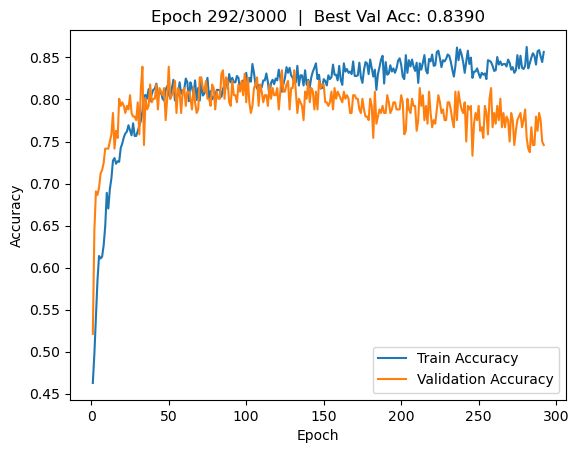

KeyboardInterrupt: 

In [12]:
# layers_list_now = [512,256,128,128,256,512]
# layers_list_now = [512, 256, 64, 256, 512]
# layers_list_now = [64, 32]
# # bt_size = 32
# bt_size = 128
# lr = 0.001
layers_list_now = best_params['layers_list']
bt_size = best_params['batch_size']
lr=best_params['lr']
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from altair import layer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.display import clear_output
# For progress bars (optional)
from tqdm import tqdm
train_acc_list = []
val_acc_list = []
best_val_acc = 0
# -----------------------------------------------------------------------------
# 1) Reproducibility & Device
# -----------------------------------------------------------------------------
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -----------------------------------------------------------------------------
# 2) Train/Validation Split
# -----------------------------------------------------------------------------
# `train` is your full DataFrame
train_df, val_df = train_test_split(data, test_size=0.15, random_state=42)

# -----------------------------------------------------------------------------
# 3) Datasets & Loaders
# -----------------------------------------------------------------------------
# `lists` is your list of feature columns in order; target_col='ID'
train_set = CustomerDataset(train_df, lists, target_col='Target')
val_set   = CustomerDataset(val_df,   lists, target_col='Target')

train_loader = DataLoader(train_set, batch_size=bt_size, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=bt_size, shuffle=False)

# -----------------------------------------------------------------------------
# 4) Model, Loss, Optimizer
# -----------------------------------------------------------------------------
model = MarketResearchModel(
    num_numeric_features=train_set[0]["features"].shape[0] - 2,
    emb_sizes=[5, 5],
    layers_list=layers_list_now,
    # depth=2,  # Set to 2 for the new model
    # hidden_dim=128
).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(w1/w0).to(device))
optimizer = optim.Adam(model.parameters(), lr = lr)

# -----------------------------------------------------------------------------
# 5) Training Loop (inline, no helper funcs)
# -----------------------------------------------------------------------------
# epochs = best_params['epochs']
epochs = 3000  # Set to 100 epochs for training
higest_state = 0
for epoch in range(1, epochs + 1):
    # — Train —
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
        x_all = batch["features"].to(device)
        y_all = batch["target"].float().to(device)

        optimizer.zero_grad()
        outputs = model(x_all)
        loss = criterion(outputs, y_all)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * y_all.size(0)
        preds = (outputs > 0.5).float()
        train_correct += (preds == y_all).sum().item()
        train_total += y_all.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)

    # — Validate —
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]  ", leave=False):
            x_all = batch["features"].to(device)
            y_all = batch["target"].float().to(device)

            outputs = model(x_all)
            loss = criterion(outputs, y_all)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            val_loss += loss.item() * y_all.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == y_all).sum().item()
            val_total += y_all.size(0)
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_acc_list.append(val_acc)
    if val_acc > best_val_acc:
        best_model_state = model.state_dict()
    best_val_acc = max(best_val_acc, val_acc)

    # Clear previous output and plot
    clear_output(wait=True)
    plt.figure()
    plt.plot(range(1, epoch + 1), train_acc_list, label='Train Accuracy')
    plt.plot(range(1, epoch + 1), val_acc_list, label='Validation Accuracy')
    plt.title(f'Epoch {epoch}/{epochs}  |  Best Val Acc: {best_val_acc:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Also print current and best in compact form
    # print(f'Epoch {epoch}/{epochs} → Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Best Val Acc: {best_val_acc:.4f}')
    # print(f"Epoch {epoch}/{epochs} → "
    #       f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
    #       f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

# -----------------------------------------------------------------------------
# 6) Save Final Model
# -----------------------------------------------------------------------------
torch.save(model.state_dict(), "final_best_model.pt")
print("✅ Model trained and saved to 'final_best_model.pt'")


In [15]:
model.load_state_dict(best_model_state)
test_set = CustomerDataset(test, lists, target_col='ID')
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)
best_model = model
best_model.eval()

MarketResearchModel(
  (imputer): ImputationLayer()
  (scaler): TrainableScaler()
  (embedding_1): Embedding(5, 10)
  (embedding_2): Embedding(5, 10)
  (ff): Sequential(
    (0): Linear(in_features=43, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.6, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.6, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.6, inplace=False)

In [16]:
IDs = []
Targets = []
for i in test_loader:
    x_all = i['features'].to(device)
    x_all = x_all.to(device)
    pred = best_model(x_all)
    pred = pred > 0.5
    pred = pred.int().cpu().numpy()
    Targets += pred.tolist()
    IDs += i['target'].tolist()
submission = pd.DataFrame({'ID': IDs, 'Target': Targets})
# comp = pd.read_csv(r'submission1.csv')
comp = pd.read_csv(r'MLP_embed-84.csv')
comp = comp.sort_values(by='ID', ignore_index=True)
submission = submission.sort_values(by='ID', ignore_index=True)
(comp['Target'] == submission['Target']).mean()  # Check accuracy of submission

0.9093610698365527

In [17]:
submission.to_csv(r'MLP_embed-83_2.csv', index=False)

In [82]:
import pandas as pd
import numpy as np

data2 = pd.read_csv(r'appian-x-iit-madras-hackathon-april-2025\train.csv')
test2 = pd.read_csv(r'appian-x-iit-madras-hackathon-april-2025\test.csv')

data2.replace('Alone', 'Single', inplace=True)
test2.replace('Absurd', 'Single', inplace=True)
data2.replace('YOLO', 'Single', inplace=True)
test2.replace('YOLO', 'Single', inplace=True)
test.replace('Alone', 'Single', inplace=True)
data.replace('Together', 'Married', inplace=True)
test.replace('Together', 'Married', inplace=True)

test.replace('Basic', '2n Cycle', inplace=True)
data.replace('Basic', '2n Cycle', inplace=True)
test.replace('Widow', 'Divorced', inplace=True)
data.replace('Widow', 'Divorced', inplace=True)

data2['Dt_Customer_1'] = pd.to_datetime(data2['Dt_Customer'],format='mixed')
data2['Dt_Customer_1'] = data2['Dt_Customer_1']-min(data2['Dt_Customer_1'])
data2['Dates']=data2['Dt_Customer_1'].dt.days

test2['Dt_Customer_1'] = pd.to_datetime(test2['Dt_Customer'],format='mixed')
test2['Dt_Customer_1'] = test2['Dt_Customer_1']-min(test2['Dt_Customer_1'])
test2['Dates']=test2['Dt_Customer_1'].dt.days
Education = {}
Marital_status = {}
A = data2['Education'].unique()
B = data2['Marital_Status'].unique()

# for i in range(len(A)):
#     Education[A[i]] = i
# for i in range(len(B)):
#     Marital_status[B[i]] = i
# data2['Education'] = data2['Education'].map(Education)
# data2['Marital_Status'] = data2['Marital_Status'].map(Marital_status)

spend_cols = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
data2['TotalSpend']       = data2[spend_cols].sum(axis=1)
for col in spend_cols:
    data2[col + '_Pct']   = data2[col] / (data2['TotalSpend'] + 1e-6)

data2['TotalAccepted']    = data2[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']].sum(axis=1)
data2['DealAcceptanceRate']= data2['NumDealsPurchases'] / (data2['NumStorePurchases'] + data2['NumWebPurchases'] + data2['NumCatalogPurchases'] + 1e-6)

In [85]:
from re import X
from catboost import train


# lists = [
#     'Year_Birth',
#     'Income',
#     'Kidhome',
#     'Teenhome',
#     'Dates',
#     'Recency',
#     'MntWines',
#     'MntFruits',
#     'MntMeatProducts',
#     'MntFishProducts',
#     'MntSweetProducts',
#     'MntGoldProds',
#     'NumWebPurchases',
#     'NumCatalogPurchases',
#     'NumStorePurchases',
#     'NumDealsPurchases',
#     'NumWebVisitsMonth',
#     'AcceptedCmp1',
#     'AcceptedCmp2',
#     'AcceptedCmp3',
#     'AcceptedCmp4',
#     'AcceptedCmp5',
#     'Complain',
#     # 'Marital_Status_Married',
#     # 'Marital_Status_Single',
#     # 'Education_Graduation',
#     # 'Education_Master',
#     # 'Education_PhD',
#     'Marital_Status',
#     'Education'
#     # 'Target'
# ]
import pandas as pd

# 1) Create the new features on your DataFrame (here called `data2`):
data2 = data2.copy()
data2['Age'] = 2025 - data2['Year_Birth']

q1, q99 = data2['Income'].quantile([0.01, 0.99])
data2['Income_clipped'] = data2['Income'].clip(q1, q99)
data2['Income_log'] = np.log1p(data2['Income_clipped'])

# If your “Dates” column is already a numeric “days since enrollment” use it directly;
# otherwise convert a datetime:
# data2['Dates'] = (pd.to_datetime('2025-04-18') - pd.to_datetime(data2['Dt_Customer'])).dt.days
data2['Tenure'] = data2['Dates']  # assuming 'Dates' already gives days since enrollment

# Total spend and spend percentages
spend_cols = [
    'MntWines','MntFruits','MntMeatProducts',
    'MntFishProducts','MntSweetProducts','MntGoldProds'
]
data2['TotalSpend'] = data2[spend_cols].sum(axis=1)
for c in spend_cols:
    data2[c + '_Pct'] = data2[c] / (data2['TotalSpend'] + 1e-6)

# Campaign response rates
cmp_cols = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']
data2['TotalAccepted']     = data2[cmp_cols].sum(axis=1)
data2['DealAcceptanceRate']= data2['NumDealsPurchases'] / (
    data2[['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']].sum(axis=1) + 1e-6
)

# 2) Now define your new feature list (in the exact order you want):
lists = [
    # Demographics & tenure
    'Age',
    'Income_log',
    'Kidhome',
    'Teenhome',
    'Tenure',
    'Recency',
    'Complain',

    # Raw spends
    *spend_cols,           # expands to the six spend columns
    'TotalSpend',
    *[c + '_Pct' for c in spend_cols],

    # Web/store/catalog activity
    'NumWebVisitsMonth',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',

    # Deal/campaign history
    'NumDealsPurchases',
    'DealAcceptanceRate',
    *cmp_cols,             # the five AcceptedCmp# columns
    'TotalAccepted',

    # Categorical
    'Marital_Status',
    'Education'
]

cat_features = ['Education','Marital_Status']
# cat_features = []
x = data2[lists].copy()
y = data2['Target'].copy()
X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42
)
X_val,X_test, y_val, y_test = train_test_split(X_val,y_val, test_size=0.5, random_state=42)

In [86]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score

# Create CatBoost Pool objects (handles cat features & missing values)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool   = Pool(X_val,   y_val,   cat_features=cat_features)

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    use_best_model=True,

    l2_leaf_reg=3,
    bagging_temperature=0.3,
    random_strength=1.0,

    task_type='GPU',
    devices='0',
    eval_metric='Accuracy',
    random_seed=42,
    early_stopping_rounds=300,
    verbose=100
)


# Fit on train, evaluate on validation
cat_model.fit(train_pool, eval_set=val_pool)

# Predict & report
preds = cat_model.predict(X_test)
print("Val Accuracy:", accuracy_score(y_test, preds))


0:	learn: 0.8371907	test: 0.7643312	best: 0.7643312 (0)	total: 73.3ms	remaining: 1m 13s
100:	learn: 0.9265762	test: 0.8216561	best: 0.8343949 (12)	total: 6.5s	remaining: 57.8s
200:	learn: 0.9624900	test: 0.8343949	best: 0.8535032 (165)	total: 13.1s	remaining: 52.1s
300:	learn: 0.9832402	test: 0.8535032	best: 0.8535032 (165)	total: 20s	remaining: 46.5s
400:	learn: 0.9880287	test: 0.8535032	best: 0.8535032 (165)	total: 27s	remaining: 40.3s
bestTest = 0.8535031847
bestIteration = 165
Shrink model to first 166 iterations.
Val Accuracy: 0.8280254777070064


In [59]:
from catboost import get_gpu_device_count
print("Available GPUs:", get_gpu_device_count())


ImportError: cannot import name 'get_gpu_device_count' from 'catboost' (c:\Users\monar\miniconda3\envs\env_torch\Lib\site-packages\catboost\__init__.py)

In [ ]:
from catboost import cv, Pool, CatBoostClassifier
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import accuracy_score

# 0) Your feature matrix X and labels y, plus cat_features list

# 1) Split off 10% for test
X_tmp, X_test, y_tmp, y_test = train_test_split(
    x, y, test_size=0.10, random_state=42, stratify=y
)

# 2) Split remaining 90% into 80% train (i.e. 80/90=0.8889) and 10% val (i.e. 10/90=0.1111)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.1111111, random_state=42, stratify=y_tmp
)

# 3) Prepare Pools
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool   = Pool(X_val,   y_val,   cat_features=cat_features)

# 4) Define grid (omit rsm for GPU mode)
param_grid = {
    'iterations':       [500, 1000],
    'depth':            [6, 8, 10],
    'learning_rate':    [0.01, 0.05],
    'l2_leaf_reg':      [1, 3, 5],
    'bagging_temperature': [0.2, 0.5, 1.0],
    # 'subsample':        [0.7, 0.8, 1.0],
    'random_strength':  [0.5, 1.0, 2.0]
}

best = {'best_cv_accuracy': 0.0}

# 5) 5‑fold CV grid search on GPU
for p in ParameterGrid(param_grid):
    params = {
        **p,
        'loss_function': 'Logloss',
        'eval_metric':   'Accuracy',
        'verbose':       False,
        'task_type':     'GPU',
        'devices':       '0'
    }

    cv_df = cv(
        train_pool,
        params,
        fold_count=5,
        partition_random_seed=42,
        early_stopping_rounds=30,
        as_pandas=True,
        plot=False
    )

    acc = cv_df['test-Accuracy-mean'].max()
    it  = int(cv_df['test-Accuracy-mean'].idxmax())

    if acc > best['best_cv_accuracy']:
        best = {**params, 'best_iter': it, 'best_cv_accuracy': acc}

    print(f"→ CV Acc {acc:.4f} @ iter {it} for {p}")

print("\n✅ Best CV run:")
for k, v in best.items():
    print(f"  {k}: {v}")

# 6) Final model: train on train + early stop on val, rollback to best iteration
final_model = CatBoostClassifier(
    iterations           = best['best_iter'],
    depth                = best['depth'],
    learning_rate        = best['learning_rate'],
    l2_leaf_reg          = best['l2_leaf_reg'],
    bagging_temperature  = best['bagging_temperature'],
    # subsample            = best['subsample'],
    random_strength      = best['random_strength'],
    loss_function        = 'Logloss',
    eval_metric          = 'Accuracy',
    # use_best_model       = True,
    task_type            = 'GPU',
    devices              = '0',
    random_seed          = 42,
    early_stopping_rounds=30,
    verbose              = 100
)

final_model.fit(train_pool, eval_set=val_pool)

# 7) Evaluate on held‑out test set
preds = final_model.predict(X_test)
test_acc = accuracy_score(y_test, preds)
print(f"\n📊 Held‑out Test Accuracy: {test_acc:.4f}")


Training on fold [0/5]
bestTest = 0.8366533865
bestIteration = 5
Training on fold [1/5]
bestTest = 0.8844621514
bestIteration = 1
Training on fold [2/5]
bestTest = 0.8525896414
bestIteration = 9
Training on fold [3/5]
bestTest = 0.84
bestIteration = 13
Training on fold [4/5]
bestTest = 0.828
bestIteration = 102
→ CV Acc 0.8356 @ iter 102 for {'bagging_temperature': 0.2, 'depth': 6, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'random_strength': 0.5}
Training on fold [0/5]
bestTest = 0.8167330677
bestIteration = 5
Training on fold [1/5]
bestTest = 0.8764940239
bestIteration = 41
Training on fold [2/5]
bestTest = 0.8565737052
bestIteration = 5
Training on fold [3/5]
bestTest = 0.832
bestIteration = 23
Training on fold [4/5]
bestTest = 0.824
bestIteration = 43
→ CV Acc 0.8356 @ iter 52 for {'bagging_temperature': 0.2, 'depth': 6, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'random_strength': 1.0}
Training on fold [0/5]
bestTest = 0.8207171315
bestIteration =